In [2]:
import sys
sys.path.insert(0, '../scripts/')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# import required packages
import numpy as np
import pandas as pd

# encoders
from sklearn.feature_extraction.text import TfidfVectorizer

# models
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV 

# metrics
import time
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import recall_score, roc_auc_score

# plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# local scripts
from text_utils import preprocess_corpus

In [4]:
# load train, validation and test sets into dataframe
df_train = pd.read_csv('../data/train_data.csv')
df_valid = pd.read_csv('../data/valid_data.csv')
df_test = pd.read_csv('../data/test_data.csv')

# combine train and validation sets
# shuffle dataframe randomly
df_train = pd.concat([df_train, df_valid]).sample(frac=1, random_state=42).reset_index(drop=True)

# shape of train and test sets: (rows, columns)
display(df_train.shape, df_test.shape)

(22568, 2)

(5642, 2)

In [5]:
# extract independent features
# preprocess text column
X_train = preprocess_corpus(df_train.headline)
X_test = preprocess_corpus(df_test.headline)

# extract dependent features
y_train = df_train.clickbait
y_test = df_test.clickbait

# size of train & test sets
display(X_train.shape, X_test.shape)

(22568,)

(5642,)

In [6]:
# first 5 datapoints of train, validation and test sets
display(df_train.head())
display(df_test.head())

,headline,clickbait
0,Your Friend Who's Back From Traveling,1
1,U.S. jury deliberates immigrant smuggler case,0
2,Top Russian Aide Calls for Less Kremlin Control,0
3,"How Well Do You Remember The Kids From ""Hey Ar...",1
4,Nick Kroll Just Said The Most Disgusting Thing...,1


,headline,clickbait
0,Australian Prime Minister denies striking a de...,0
1,The Bottom for Housing Is Probably Not Near,0
2,Do You Remember The Hogwarts House Of These Mi...,1
3,Here's Every Tweet Drake Has Ever Favorited,1
4,What Would Zooey Deschanel Name You,1


# TF-IDF Transformation

In [7]:
# tf-idf transformation
# instantiate a CountVectorizer
tfidf_vectorizer = TfidfVectorizer(min_df=5)

# train and construct bag of words
X_train_tfidf = pd.DataFrame(tfidf_vectorizer.fit_transform(X_train).toarray(), columns=tfidf_vectorizer.get_feature_names_out())
X_test_tfidf = pd.DataFrame(tfidf_vectorizer.transform(X_test).toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# shape of document matrix: (rows, columns)
display(X_train_tfidf.shape, X_test_tfidf.shape)

(22568, 4017)

(5642, 4017)

In [8]:
# first 5 datapoints of transformed train, validation & test sets
display(X_train_tfidf.head())
display(X_test_tfidf.head())

,aaron,abandon,abc,abduct,able,aboard,abortion,abroad,absolute,absolutely,...,zelda,zendaya,zero,zimbabwe,zimbabwean,zodiac,zombie,zone,zoo,zoolander
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,aaron,abandon,abc,abduct,able,aboard,abortion,abroad,absolute,absolutely,...,zelda,zendaya,zero,zimbabwe,zimbabwean,zodiac,zombie,zone,zoo,zoolander
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# utility function
# plot confusion matrix using sns heatmap
def plot_confusion_matrix(cf_matrix, title, xlabel='Predicted', ylabel='Actual', ticklabels=None, figsize=(8,4), fontdict={'fontsize':12}):
    
    # extract counts from confusion matrix
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]

    # calculate proportions from confusion matrix
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    
    # create annotations for plot
    annotations = [f'{count}\n{percentage}\n'.format(count, percentage) for count, percentage in zip(group_counts, group_percentages)]
    annotations = np.asarray(annotations).reshape(cf_matrix.shape)

    plt.figure(figsize = figsize, dpi=100)
    ax = sns.heatmap(cf_matrix, annot=annotations, fmt='', cmap='Blues')

    # set title
    ax.set_title(title, fontdict=fontdict)
    
    # set axes labels
    ax.set_xlabel(xlabel, fontdict=fontdict)
    ax.set_ylabel(ylabel, fontdict=fontdict)

    # tick labels - List must be in alphabetical order
    if ticklabels:
        # set axes tick labels
        ax.xaxis.set_ticklabels(ticklabels)
        ax.yaxis.set_ticklabels(ticklabels)

    # display the visualization of the confusion matrix.
    plt.show()

## Hyperparameter Tuning: Kernel SVM + TF-IDF

In [8]:
# create a map of params to be optimized
params = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'sigmoid'],
}

# instantiate a GridSearchCV object with SVM model and params
grid_search_cv = GridSearchCV(SVC(), params, scoring='roc_auc', verbose=4, cv=5)

# perform grid search
grid_search_cv.fit(X_train_tfidf, y_train.values.ravel())

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .................C=0.1, kernel=rbf;, score=0.983 total time=12.5min
[CV 2/5] END .................C=0.1, kernel=rbf;, score=0.981 total time=12.4min
[CV 3/5] END .................C=0.1, kernel=rbf;, score=0.982 total time=12.5min
[CV 4/5] END .................C=0.1, kernel=rbf;, score=0.982 total time=12.7min
[CV 5/5] END .................C=0.1, kernel=rbf;, score=0.981 total time=12.4min
[CV 1/5] END .............C=0.1, kernel=sigmoid;, score=0.985 total time= 7.7min
[CV 2/5] END .............C=0.1, kernel=sigmoid;, score=0.983 total time= 7.6min
[CV 3/5] END .............C=0.1, kernel=sigmoid;, score=0.985 total time= 7.7min
[CV 4/5] END .............C=0.1, kernel=sigmoid;, score=0.986 total time= 8.0min
[CV 5/5] END .............C=0.1, kernel=sigmoid;, score=0.984 total time= 7.7min
[CV 1/5] END ...................C=1, kernel=rbf;, score=0.988 total time=17.8min
[CV 2/5] END ...................C=1, kernel=rbf;,

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'kernel': ['rbf', 'sigmoid']},
             scoring='roc_auc', verbose=4)

In [9]:
# display the best parameters for XGBoost and the best score
grid_search_cv.best_params_, grid_search_cv.best_score_

({'C': 1, 'kernel': 'rbf'}, 0.9878517280868623)

## Train & Test: Kernel SVM + TF-IDF

In [10]:
# train Kernel SVM on tf-idf with best paramters
# instantiate a Kernel SVM
model = SVC(C=1, kernel='rbf')

# training start
print('training...')
start_time = time.time()

model.fit(X_train_tfidf, y_train.values.ravel())

# training end
end_time = time.time()
print('training completed:', '{:.2f}'.format(end_time - start_time), 'seconds')

# testing start
print('testing...')
start_time = time.time()

# make predictions on test set
y_pred = model.predict(X_test_tfidf)
        
# testing end
end_time = time.time()
print('testing completed:', '{:.2f}'.format(end_time - start_time), 'seconds')

training...
training completed: 1412.29 seconds
testing...
testing completed: 213.24 seconds


accuracy 0.9505494505494505
recall 0.9578371419375603
f1-score 0.9552238805970149
roc_auc 0.9497272494697664


,F1 Score
0,0.944785
1,0.955224


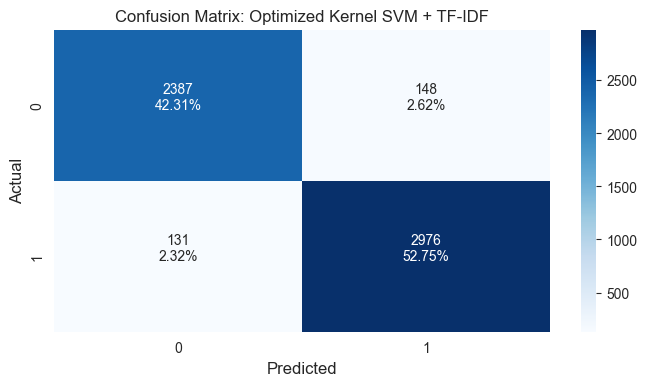

In [11]:
# results: kernel svm with best parameters
# accuracy
acc = accuracy_score(y_test, y_pred)
print('accuracy', acc)

# recall
recall = recall_score(y_test, y_pred)
print('recall', recall)

# f1 score
f1 = f1_score(y_test, y_pred)
print('f1-score', f1)

# roc_auc
roc = roc_auc_score(y_test, y_pred)
print('roc_auc', roc)

# class label-wise f1 score
# 0 - Not Phishing
# 1 - Phishing
display(pd.DataFrame(np.asarray(f1_score(y_test, y_pred, average=None)).T, columns=['F1 Score'], index=['0', '1']))

# confusion matrix
# plot heatmap
plot_confusion_matrix(
    confusion_matrix(y_test.values.ravel(), y_pred),
    'Confusion Matrix: Optimized Kernel SVM + TF-IDF'
)